# Intro
<p>This notebook presents a <code>regime_switching</code> module usage scenario, based on chapter 5.4 from Kim and Nelson and Kim's code sample http://econ.korea.ac.kr/~cjkim/MARKOV/programs/kim_je.opt.</p>
<p>Lam's Generalized Hamilton Model has the following notation:</p>
<p>$$ y_t = n_t + x_t $$</p>
<p>$$ n_t = n_{t-1} + \delta_{S_t} $$</p>
<p>$$ \phi(L) x_t = x_t - \phi_1 x_{t-1} - \phi_2 x_{t-2} = v_t $$</p>
<p>$$ v_t \sim i.i.d. N(0, \sigma^2) $$</p>
<p>$$ \delta_{S_t} = \delta_0 + \delta_1 S_t $$</p>
<p>$$ Pr[S_t = 1 \mid S_{t-1} = 1] = p, Pr[S_t = 0 \mid S_{t-1} = 0] = q $$</p>
We assume, that roots of equation $ \phi(x) = 0 $ lie inside the unit circle.<br>
A state-space representation for this model:
<p>$$ \Delta y_t = [1 -1] \begin{bmatrix} x_t \\ x_{t-1} \end{bmatrix} + \delta_{S_t} $$</p>
<p>$$ ( \Delta y_t = H \beta_t + \delta_{S_t} ) $$</p>
<p>$$ \begin{bmatrix} x_t \\ x_{t-1} \end{bmatrix} = \begin{bmatrix} \phi_1 & \phi_2 \\ 1 & 0 \end{bmatrix} \begin{bmatrix} x_{t-1} \\ x_{t-2} \end{bmatrix} + \begin{bmatrix} 1 \\ 0 \end{bmatrix} v_t $$</p>
<p>$$ ( \beta_t = F \beta_{t-1} + G v_t ) $$</p>
<p>The code presented below shows maximum likelihood estimation for this model in two ways, depending on starting parameters for optimization.</p>
<ul>
<li>The first way is to start with some apriori known parameters, which are close to the global maximum of likelihood. This approach and parameter values are taken from the code, referenced above.</li>
<li>The second is to estimate parameters for natural non-switching analog (i.e. when $S_t$ doesn't change with time) and then use achieved values as the starting parameters for switching model fit.</li>
</ul>

# Learnings

Punkte:
- Kim 1994 hat ein Schätzverfahren zum Fitten von Markov-switching State Space Models vorgeschlagen
    - Dieses Verfahren wird verwendet um Lam's verallgemeinertes Markov Modell zu schätzen
- Es werden 2 Klassen definiert:
    - Kim 1994 ohne switching

# Init 

In [1]:
"""
Kim's (1994) MLE model of real GNP decomposition into stochastic trend and
autoregressive component (chapter 5.4 of Kim and Nelson, 1999).

Author: Valery Likhosherstov
License: Simplified-BSD
"""

import numpy as np
from statsmodels.tsa.statespace.api import MLEModel
from statsmodels.tsa.statespace.regime_switching.api import SwitchingMLEModel
from statsmodels.tsa.statespace.regime_switching.tests.results import results_kim1994

# Useful methods, forcing AR coefficients to be stationary

def _transform_ar_coefs(unconstrained):
    # `root1` and `root2` are roots of quadratic equation, lying inside the unit circle
    root1 = unconstrained[0] / (1 + np.abs(unconstrained[0]))
    root2 = unconstrained[1] / (1 + np.abs(unconstrained[1]))
    # return coefficients of the equation, which are constrained values
    return (root1 + root2, -root1 * root2)

def _untransform_ar_coefs(constrained):
    # Constrained AR coefficients
    b_coef = constrained[0]
    c_coef = constrained[1]
    # Get the roots of equation with these coefficients
    root1 = (b_coef - np.sqrt(b_coef * b_coef + 4 * c_coef)) / 2.0
    root2 = (b_coef + np.sqrt(b_coef * b_coef + 4 * c_coef)) / 2.0
    # Unconstrained representation of the roots (which lie inside the unit circle)
    unconstrained_roots = (root1 / (1 - np.sign(root1) * root1),
            root2 / (1 - np.sign(root2) * root2))
    return unconstrained_roots

def get_model_matrices(params):
    
    # Transform parameters of the model into matrices of Markov switching state space
    # representation.
    # Following logic is copied from GAUSS code

    # Model attributes
    k_regimes = 2
    k_endog = 1
    k_states = 2
    k_posdef = 1

    # Unpacking parameters of the model
    p, q, phi_1, phi_2, sigma, delta_0, delta_1 = params

    # Constructing regime transition matrix
    regime_transition = np.zeros((k_regimes, k_regimes))
    regime_transition[:, :] = [[q, p], [1 - q, 1 - p]]

    # Constructing design matrix - H
    design = np.zeros((k_endog, k_states, 1))
    design[0, :, 0] = [1, -1]

    # Constructing observation intercept matrix - \delta_{S_t}, which is a single value
    # Notice, that this is the only switching matrix for this model
    obs_intercept = np.zeros((k_regimes, k_endog, 1))
    obs_intercept[:, 0, 0] = [delta_0, delta_1]

    # Constructing state transition matrix - F
    transition = np.zeros((k_states, k_states, 1))
    transition[:, :, 0] = [[phi_1, phi_2], [1, 0]]

    # Constructing selection matrix - G
    selection = np.zeros((k_states, k_posdef, 1))
    selection[:, :, 0] = [[1], [0]]

    # Constructing state covariance matrix \sigma_2, which is a single value
    state_cov = np.zeros((k_posdef, k_posdef, 1))
    state_cov[0, 0, 0] = sigma**2

    # Constructing initial state - \beta_{0|0}
    initial_state_mean = np.zeros((k_states,))

    # Constructing initial state covariance - P_{0|0}
    
    transition_outer_sqr = np.zeros((4, 4))

    for i in range(0, 2):
        for j in range(0, 2):
            transition_outer_sqr[i * 2:i * 2 + 2, j * 2:j * 2 + 2] = transition[i, j, 0] * transition[:, :, 0]

    nonpos_def_state_cov = selection.dot(state_cov).dot(selection.T)

    initial_state_cov_vector = np.linalg.inv(np.eye(4) -
            transition_outer_sqr).dot(nonpos_def_state_cov.reshape(-1, 1))

    initial_state_cov = initial_state_cov_vector.reshape(k_states, k_states).T

    return (regime_transition,
            design,
            obs_intercept,
            transition,
            selection,
            state_cov,
            initial_state_mean,
            initial_state_cov)

class Linear_Kim1994Model(MLEModel):
    
    # Kim's model without switching
    # This class is used to estimate starting parameters when non-switching
    # initialization feature is used

    @property
    def start_params(self):
        # Start params - just transformed vector of ones
        dtype = self.ssm.dtype
        return self.transform_params(np.ones((4,), dtype=dtype))
    
    def transform_params(self, unconstrained):
        # Transform unconstrained parameters used by optimizer to constrained
        # parameters used in likelihood evaluation
        constrained = np.array(unconstrained)
        constrained[:2] = _transform_ar_coefs(unconstrained[:2])
        return constrained

    def untransform_params(self, constrained):
        # Untransform constrained parameters used in likelihood evalutation to
        # unconstrained parameters used by optimizer
        unconstrained = np.array(constrained)
        unconstrained[:2] = _untransform_ar_coefs(constrained[:2])
        return unconstrained

    def update(self, params, *args, **kwargs):

        # Update state space representation according to parameters

        # This does transformation if parameters are untransformed
        params = super(Linear_Kim1994Model, self).update(params, *args,
                **kwargs)

        # Get state space matrices
        # This method is designed to work with switching model, but with some
        # tricks it's compatible with non-switching one
        _, self['design'], obs_intercept, self['transition'], \
                self['selection'], self['state_cov'], initial_state_mean, \
                initial_state_cov = get_model_matrices(np.hstack((0.5, 0.5, params, 0)))
        self['obs_intercept'] = obs_intercept[0]
        self.initialize_known(initial_state_mean, initial_state_cov)


class Kim1994Model(SwitchingMLEModel):
    
    # Kim's (1994) MLE model of real GNP

    def __init__(self, *args, **kwargs):

        super(Kim1994Model, self).__init__(*args, **kwargs)

        # Set parameter slices
        # `self.parameters` is an instance of `MarkovSwitchingParams` class
        self.parameters['phi'] = [False, False]
        self.parameters['sigma'] = [False]
        self.parameters['delta'] = [True]
        
        # Set parameter names for a nice output (regime transition prob names are already in `_param_names`)
        self._param_names += ['phi1', 'phi2', 'sigma', 'delta0', 'delta1']

    def get_nonswitching_model(self):
        # This instance will perform non-switching fitting for starting parameters estimation
        # (if `fit_nonswitching_first` option is set to `True` in `fit` method).
        return Linear_Kim1994Model(endog=self.endog, k_states=self.k_states, k_posdef=1)
    
    def update_params(self, params, nonswitching_params):
        
        # This method is used, when non-switching fitting is done, and we need to get
        # switching model starting params.
        
        # nonswitching_model_params consists of 4 values: (phi_1, phi_2, sigma, delta).
        params[self.parameters['phi']] = nonswitching_params[:2]
        params[self.parameters['sigma']] = nonswitching_params[2]
        
        # Need to add some determinate noise to break the symmetry of regimes
        params[self.parameters[0, 'delta']] = nonswitching_params[3] - 1e-2
        params[self.parameters[1, 'delta']] = nonswitching_params[3] + 1e-2
        
        return params

    # Parameters vector for Markov switching model can be logically splitted
    # into two parts:
    # - regime transition parameters, which define regime transtition matrix.
    # - model parameters, which describe common and different for every
    #    regime set of parameters, which are used to recover state space
    #    representations of every regime.
    
    # Regime transition parameters, by default, use logistic transformation, while model
    # parameters transformation is user-defined.
    
    def transform_model_params(self, unconstrained):

        constrained = np.array(unconstrained)

        # Force stationarity of AR coefficients
        constrained[self.parameters['phi']] = \
                _transform_ar_coefs(unconstrained[self.parameters['phi']])
        return constrained

    def untransform_model_params(self, constrained):

        unconstrained = np.array(constrained)

        # Force stationarity of AR coefficients
        unconstrained[self.parameters['phi']] = \
                _untransform_ar_coefs(constrained[self.parameters['phi']])
        return unconstrained

    def update(self, params, **kwargs):
        # `params` vector here contains both groups of parameters and has the size of 7:
        # `(p, q, phi_1, phi_2, sigma, delta_1, delta_2)`
        params = super(Kim1994Model, self).update(params, **kwargs)

        # Updating Markov switching state space representation of the model
        self['regime_transition'], self['design'], self['obs_intercept'], \
                self['transition'], self['selection'], self['state_cov'], \
                initial_state_mean, initial_state_cov = get_model_matrices(params)

        # Updating initialization of the model
        self.initialize_known(initial_state_mean, initial_state_cov)
        self.initialize_stationary_regime_probs()

# Model 1

In [2]:
# This code presents supposed scenario of switching MLE model usage

# Model attributes
k_regimes = 2
k_endog = 1
k_states = 2
k_posdef = 1

# Prepare endogenous data for the model - taken from test dataset
true = results_kim1994.kim_je
data = np.array(true['data'])
data = np.log(data)*100
obs = np.array(data[1:152] - data[:151])
start = true['start']

# Model instantiation
model = Kim1994Model(k_regimes, obs, k_states, loglikelihood_burn=start,
        k_posdef=k_posdef)

# Authors use untransformed values to start from.
results = model.fit(
        transformed=False)

# Print results
print(results.summary())

                  Markov Switching Statespace Model Results                   
Dep. Variable:                      y   No. Observations:                  151
Model:                   Kim1994Model   Log Likelihood                -179.353
Date:                Wed, 01 Jun 2022   AIC                            372.706
Time:                        11:18:25   BIC                            393.827
Sample:                             0   HQIC                           381.287
                                - 151                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Pr[0->0]       0.0502          0        inf      0.000       0.050       0.050
Pr[1->0]       0.4324          0        inf      0.000       0.432       0.432
phi1           1.3046          0        inf      0.0

/Users/lukas/Workspace Lukas/statsmodels-d17aa4443f513efc4fa449bfe9729f92b74a4dad/statsmodels/base/model.py:999: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/Users/lukas/Workspace Lukas/statsmodels-d17aa4443f513efc4fa449bfe9729f92b74a4dad/statsmodels/tsa/statespace/mlemodel.py:1962: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse


In [4]:
# Example of non-switching initialization feature usage

# When `fit_nonswitching_first=True` is set, a non-switching model from
# `get_nonswitching_model` is fitted to data.

# If `start_params` argument is not provided, the model uses `start_params` property.
# In our case this is transformed vector of ones. After non-switching fit, we need to translate
# the solution into switching parameters space. This is done via `update_params` method, which
# takes blank parameter vector and updates it using non-switching solution.

# You can also specify regime transition probabilities in blank parameter vector by adding
# `default_transition_probs` keyword argument with appropriate left-stochastic matrix. If no
# `default_transition_probs` is provided, all transition probabilities are set to equal values.
nonswitching_fit_results = model.fit(fit_nonswitching_first=True)

# Print results
print(nonswitching_fit_results.summary())

                  Markov Switching Statespace Model Results                   
Dep. Variable:                      y   No. Observations:                  151
Model:                   Kim1994Model   Log Likelihood                -179.353
Date:                Wed, 01 Jun 2022   AIC                            372.706
Time:                        11:05:03   BIC                            393.827
Sample:                             0   HQIC                           381.287
                                - 151                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Pr[0->0]       0.0502          0        inf      0.000       0.050       0.050
Pr[1->0]       0.4324          0        inf      0.000       0.432       0.432
phi1           1.3046          0        inf      0.0

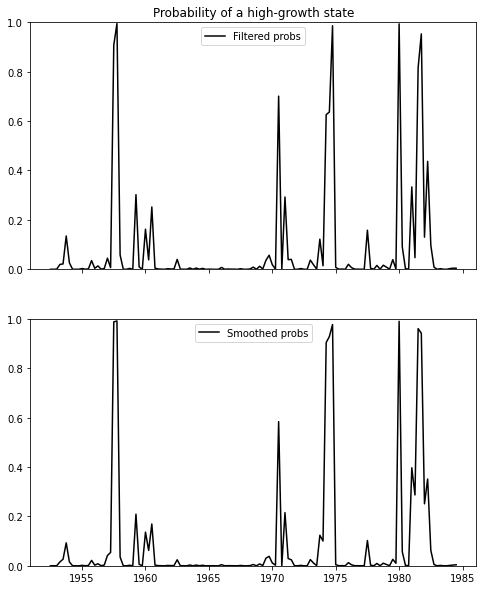

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

# Filtering and smoothing of the data

years = np.arange(1947, 1987.25, 0.25)[:151]

# Example of results object usage

filtering_results = model.filter(results.params, return_ssm=True)
filtered_high_growth_state_probs = filtering_results.filtered_regime_probs[0]

smoothing_results = model.smooth(results.params, return_ssm=True)
smoothed_high_growth_state_probs = smoothing_results.smoothed_regime_probs[0]

# Plot the result

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8,10))

ax1.set_ylim((0, 1))
ax1.set_title('Probability of a high-growth state')

ax1.plot(years[start:], filtered_high_growth_state_probs[start:], 'k', label='Filtered probs')
ax1.legend(loc='upper center')
ax2.plot(years[start:], smoothed_high_growth_state_probs[start:], 'k', label='Smoothed probs')
ax2.legend(loc='upper center');

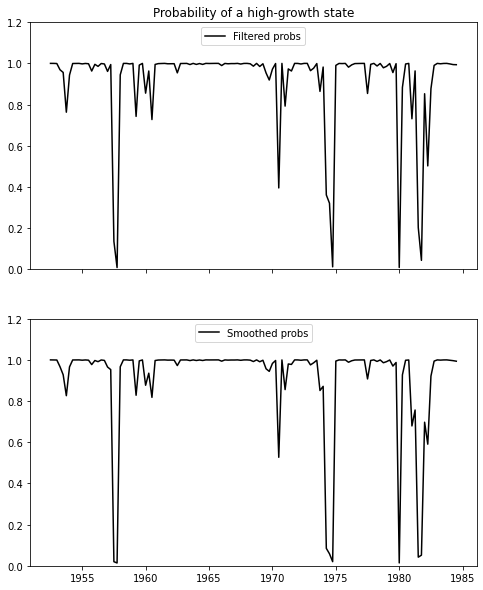

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

# Filtering and smoothing of the data

years = np.arange(1947, 1987.25, 0.25)[:151]

# Example of results object usage

filtering_results = model.filter(results.params, return_ssm=True)
filtered_high_growth_state_probs = filtering_results.filtered_regime_probs[1]

smoothing_results = model.smooth(results.params, return_ssm=True)
smoothed_high_growth_state_probs = smoothing_results.smoothed_regime_probs[1]

# Plot the result

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8,10))

ax1.set_ylim((0, 1.2))
ax1.set_title('Probability of a high-growth state')

ax1.plot(years[start:], filtered_high_growth_state_probs[start:], 'k', label='Filtered probs')
ax1.legend(loc='upper center')
ax2.plot(years[start:], smoothed_high_growth_state_probs[start:], 'k', label='Smoothed probs')
ax2.legend(loc='upper center');

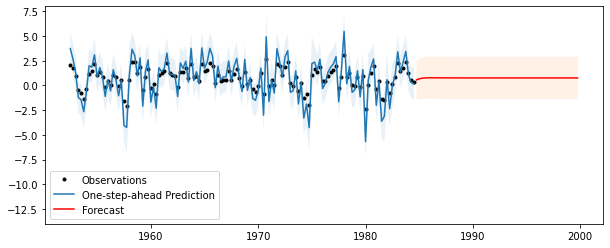

In [5]:
# Example of Kim prediction and forecasting

# Year to forecast until
forecast_end = 2000

# Range of years for forecast
forecast_years = np.arange(years[-1] + 0.25, forecast_end, 0.25)

# Perform prediction and forecasting
predict = results.get_prediction()
forecast = results.get_forecast(steps=forecast_years.shape[0])

# Plot prediction and forecast

fig, ax = plt.subplots(figsize=(10,4))

ax.plot(years[start:], obs[start:], 'k.', label='Observations')
ax.plot(years[start:], predict.predicted_mean[start:], label='One-step-ahead Prediction')
predict_ci = predict.conf_int(alpha=0.05)
ax.fill_between(years[start:], predict_ci.iloc[start:, 0], predict_ci.iloc[start:, 1], alpha=0.1)

ax.plot(forecast_years, forecast.predicted_mean, 'r', label='Forecast')
forecast_ci = forecast.conf_int()
ax.fill_between(forecast_years, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], alpha=0.1)

ax.set_ylim((-14, 8))
legend = ax.legend(loc='lower left');

<h1>References</h1>
<p>Kim, Chang-Jin, and Charles R. Nelson. 1999.<br>
"State-Space Models with Regime Switching: Classical and Gibbs-Sampling Approaches with Applications".<br>
MIT Press Books. The MIT Press.</p>